In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")  # Suppresses warnings

In [3]:
# Load the dataset
df = pd.read_csv("patient_dataset.csv")
df.head()

,age,gender,chest_pain_type,blood_pressure,cholesterol,max_heart_rate,exercise_angina,plasma_glucose,skin_thickness,insulin,bmi,diabetes_pedigree,hypertension,heart_disease,residence_type,smoking_status
0,24,1.0,4,250,139,212,0,108.0,33.0,109.0,37.999303,0.480277,1,1,Urban,Smoker
1,29,0.0,4,132,187,147,0,202.0,42.0,NaN,25.588346,0.283986,1,1,Urban,Unknown
2,46,0.0,3,271,185,193,0,149.0,43.0,102.0,37.892029,2.472309,1,0,Rural,Non-Smoker
3,73,NaN,2,102,200,125,0,105.0,77.0,165.0,18.660241,1.472052,0,1,Rural,Smoker
4,49,1.0,3,91,163,192,0,162.0,31.0,170.0,12.767980,0.537627,1,1,Rural,Smoker


In [4]:
# Check the shape (rows, columns)
print("Dataset Shape:", df.shape)

# Check data types and non-null counts
print("\nData Types and Non-Null Counts:")
print(df.info())

# Get basic statistical summary for numerical columns
print("\nStatistical Summary:")
print(df.describe())

Dataset Shape: (6000, 16)

Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                6000 non-null   int64  
 1   gender             5528 non-null   float64
 2   chest_pain_type    6000 non-null   int64  
 3   blood_pressure     6000 non-null   int64  
 4   cholesterol        6000 non-null   int64  
 5   max_heart_rate     6000 non-null   int64  
 6   exercise_angina    6000 non-null   int64  
 7   plasma_glucose     5391 non-null   float64
 8   skin_thickness     5386 non-null   float64
 9   insulin            5432 non-null   float64
 10  bmi                6000 non-null   float64
 11  diabetes_pedigree  6000 non-null   float64
 12  hypertension       6000 non-null   int64  
 13  heart_disease      6000 non-null   int64  
 14  residence_type     5545 non-null   object 
 15  smoking_statu

In [5]:
# Handle missing values
df['gender'].fillna(df['gender'].mode()[0], inplace=True)  # Median imputation for gender
df['plasma_glucose'].fillna(df['plasma_glucose'].median(), inplace=True)
df['skin_thickness'].fillna(df['skin_thickness'].median(), inplace=True)
df['insulin'].fillna(df['insulin'].median(), inplace=True)
df['residence_type'].fillna(df['residence_type'].mode()[0], inplace=True)

In [6]:
# 1. Identify outliers using IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers, lower_bound, upper_bound

In [7]:
# 2. Identify outliers using Z-score method
def detect_outliers_zscore(df, column, threshold=3):
    z_scores = stats.zscore(df[column])
    outliers = df[abs(z_scores) > threshold][column]
    return outliers

In [8]:
# 3. Handle physiologically impossible values
def fix_impossible_values(df):
    # Blood pressure can't be 0
    df.loc[df['blood_pressure'] == 0, 'blood_pressure'] = np.nan

    # Fix other impossible values based on medical knowledge
    df.loc[df['cholesterol'] > 600, 'cholesterol'] = np.nan  # Extremely rare to be above 600
    df.loc[df['bmi'] < 10, 'bmi'] = np.nan  # BMI below 10 is life-threatening

    return df

In [9]:
# 4. Handle statistical outliers
def handle_outliers(df, column, method='cap'):
    """
    Handle outliers in specified column
    method: 'cap' to cap at bounds, 'remove' to set as NaN
    """
    outliers, lower_bound, upper_bound = detect_outliers_iqr(df, column)

    if method == 'cap':
        # Cap the outliers at the boundaries
        df.loc[df[column] < lower_bound, column] = lower_bound
        df.loc[df[column] > upper_bound, column] = upper_bound
    elif method == 'remove':
        # Set outliers as NaN
        df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), column] = np.nan

    return df, len(outliers)

# Apply outlier handling to the dataset
df = fix_impossible_values(df)

In [10]:
# List of numerical columns to check for outliers
numerical_columns = ['age', 'blood_pressure', 'cholesterol', 'max_heart_rate',
                     'plasma_glucose', 'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree']

# Apply outlier handling to each column
outlier_summary = {}
for column in numerical_columns:
    df, count = handle_outliers(df, column, method='cap')
    outlier_summary[column] = count

# Print outlier summary
print("Outlier Summary (IQR method):")
for column, count in outlier_summary.items():
    print(f"{column}: {count} outliers detected and handled")

Outlier Summary (IQR method):
age: 0 outliers detected and handled
blood_pressure: 487 outliers detected and handled
cholesterol: 0 outliers detected and handled
max_heart_rate: 0 outliers detected and handled
plasma_glucose: 0 outliers detected and handled
skin_thickness: 0 outliers detected and handled
insulin: 0 outliers detected and handled
bmi: 0 outliers detected and handled
diabetes_pedigree: 0 outliers detected and handled


In [11]:
# Fill remaining missing values after outlier handling
for column in numerical_columns:
    df[column].fillna(df[column].median(), inplace=True)

#  Feature Engineering

In [12]:
# Age groups - clinical risk often correlates with age brackets
df['age_group'] = pd.cut(df['age'],
                          bins=[0, 30, 45, 65, 85, 100],
                          labels=['young_adult', 'adult', 'middle_aged', 'senior', 'elderly'])

# BMI categories according to WHO standards
df['bmi_category'] = pd.cut(df['bmi'],
                             bins=[0, 18.5, 25, 30, 35, 100],
                             labels=['underweight', 'normal', 'overweight', 'obese', 'severely_obese'])

# Blood pressure categories based on clinical guidelines
df['bp_category'] = pd.cut(df['blood_pressure'],
                            bins=[0, 120, 140, 160, 180, 300],
                            labels=['normal', 'elevated', 'hypertension1', 'hypertension2', 'hypertensive_crisis'])

# Cholesterol levels category
df['cholesterol_category'] = pd.cut(df['cholesterol'],
                                     bins=[0, 200, 240, 300],
                                     labels=['normal', 'borderline', 'high'])

# Create combination risk factors
# Cardiovascular risk - combine multiple factors
df['cv_risk_count'] = ((df['heart_disease'] == 1).astype(int) +
                        (df['hypertension'] == 1).astype(int) +
                        (df['cholesterol'] > 240).astype(int) +
                        (df['smoking_status'] == 'Smoker').astype(int))

# Metabolic risk - diabetes indicators
df['diabetes_risk'] = np.where(
    (df['plasma_glucose'] > 125) & (df['bmi'] > 30), 'high',
    np.where((df['plasma_glucose'] > 100) | (df['bmi'] > 25), 'moderate', 'low')
)

# Age-related risk factor
df['age_risk'] = np.where(df['age'] > 65, 'high',
                          np.where(df['age'] > 45, 'moderate', 'low'))

# Heart rate abnormality
df['hr_abnormal'] = np.where(
    (df['max_heart_rate'] < 60) | (df['max_heart_rate'] > 100), 1, 0
)

# Chest pain severity (assuming type 1 is most severe, type 4 is least severe)
df['severe_chest_pain'] = np.where(df['chest_pain_type'] <= 2, 1, 0)

# Comprehensive risk score (example approach - can be refined with clinical expertise)
df['risk_score'] = (
    # Cardiovascular components
    df['cv_risk_count'] * 2 +
    (df['severe_chest_pain'] * 3) +
    (df['hr_abnormal'] * 2) +

    # Convert BP category to numeric and weight it
    pd.factorize(df['bp_category'])[0] * 0.5 +

    # Convert cholesterol category to numeric and weight it
    pd.factorize(df['cholesterol_category'])[0] * 0.5 +

    # Metabolic components
    (pd.factorize(df['diabetes_risk'])[0] * 0.5) +

    # Age component
    (pd.factorize(df['age_risk'])[0] * 0.5)
)


In [13]:
# Define feature groups for preprocessing
numerical_features = ['age', 'blood_pressure', 'cholesterol', 'max_heart_rate',
                     'bmi', 'diabetes_pedigree', 'plasma_glucose',
                     'skin_thickness', 'insulin', 'cv_risk_count', 'risk_score']

binary_features = ['exercise_angina', 'hypertension', 'heart_disease',
                  'severe_chest_pain', 'hr_abnormal']

categorical_features = ['gender', 'chest_pain_type', 'residence_type', 'smoking_status',
                       'age_group', 'bmi_category', 'bp_category',
                       'cholesterol_category', 'diabetes_risk', 'age_risk']


# Prepare the data for clustering

In [14]:
# Handle missing values in numerical features
for feature in numerical_features:
    if feature in df.columns:
        df[feature].fillna(df[feature].median(), inplace=True)

# Handle missing values in categorical features
for feature in categorical_features:
    if feature in df.columns:
        df[feature].fillna(df[feature].mode()[0], inplace=True)


In [15]:
# Define the features to use for clustering
clustering_features = ['Balance', 'Qual_miles', 'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo',
                       'Flight_trans_12', 'Days_since_enroll', 'Award?', 'Some_Other_Feature', 'Another_Feature']


In [16]:
# Ensure only available columns are selected
clustering_features = [feature for feature in clustering_features if feature in df.columns]

In [17]:

# Handle missing values (Fill NaN with median)
df[clustering_features] = df[clustering_features].fillna(df[clustering_features].median())

In [18]:
# Create a dataframe for clustering with selected features
clustering_features = numerical_features + binary_features
X_clustering = df[clustering_features].copy()

In [19]:
# Standardize numerical features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[clustering_features])
X_scaled_df = pd.DataFrame(X_scaled, columns=clustering_features)


In [20]:

# Print shape to verify
print("Shape of X_scaled:", X_scaled.shape)
print("Number of feature names:", len(clustering_features))

# Display first few rows
print(X_scaled_df.head())

Shape of X_scaled: (6000, 16)
Number of feature names: 16
        age  blood_pressure  cholesterol  max_heart_rate       bmi  \
0 -1.411160        2.428238    -1.340840        1.537505  0.693118   
1 -1.173253       -0.049320    -0.432369        0.045985 -0.374450   
2 -0.364370        2.428238    -0.470222        1.101522  0.683890   
3  0.920327       -0.743962    -0.186325       -0.458838 -0.970392   
4 -0.221626       -0.998664    -0.886605        1.078576 -1.477234   

   diabetes_pedigree  plasma_glucose  skin_thickness   insulin  cv_risk_count  \
0          -1.180427       -1.070635       -1.223635 -0.739307       1.201247   
1          -1.464958        0.820768       -0.815278 -0.019588       0.198955   
2           1.707102       -0.245661       -0.769905 -0.991209      -0.803337   
3           0.257191       -1.130999        0.772778  1.275906       0.198955   
4          -1.097297        0.015916       -1.314381  1.455835       1.201247   

   risk_score  exercise_angina  hy

Testing with 2 clusters...


Testing with 3 clusters...
Testing with 4 clusters...
Testing with 5 clusters...
Testing with 6 clusters...
Testing with 7 clusters...
Testing with 8 clusters...
Testing with 9 clusters...
Testing with 10 clusters...


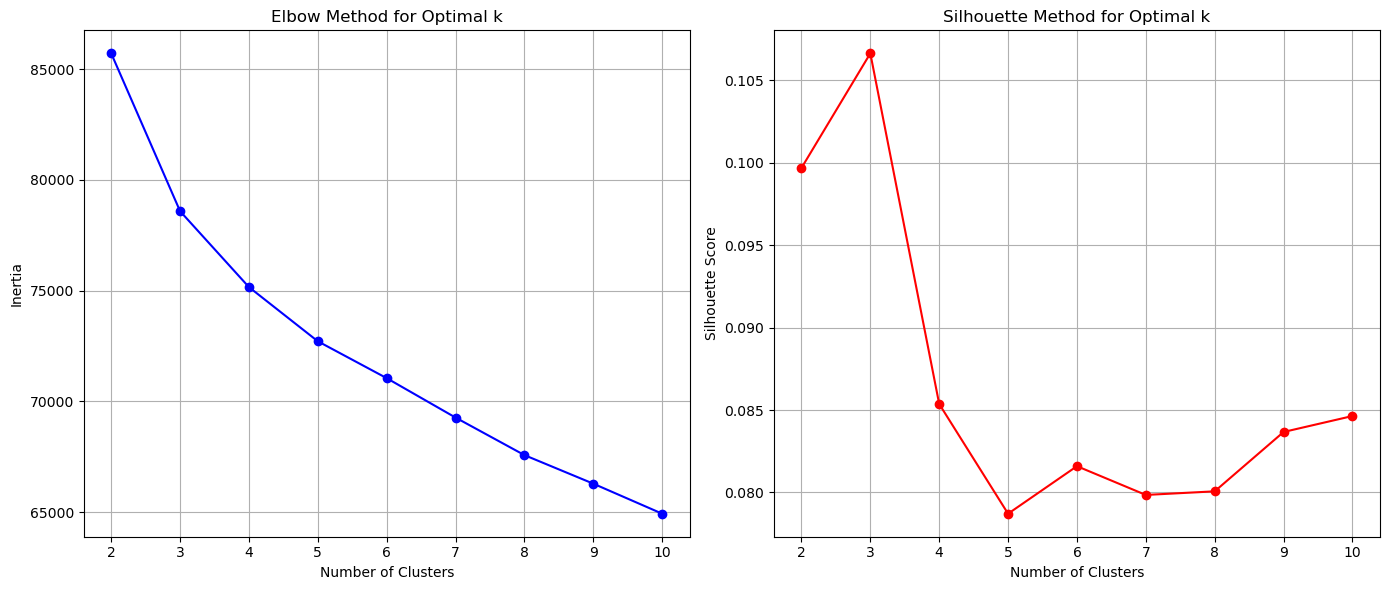

In [21]:
# Determine optimal number of clusters
max_clusters = 10
inertia_values = []
silhouette_scores = []

for k in range(2, max_clusters+1):
    print(f"Testing with {k} clusters...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow curve
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters+1), inertia_values, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters+1), silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# Determine optimal clusters from silhouette score
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")
print(f"Silhouette score with {optimal_k} clusters: {max(silhouette_scores):.3f}")

Optimal number of clusters based on silhouette score: 3
Silhouette score with 3 clusters: 0.107


In [23]:
# Apply KMeans with the optimal number of clusters
best_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = best_kmeans.fit_predict(X_scaled)


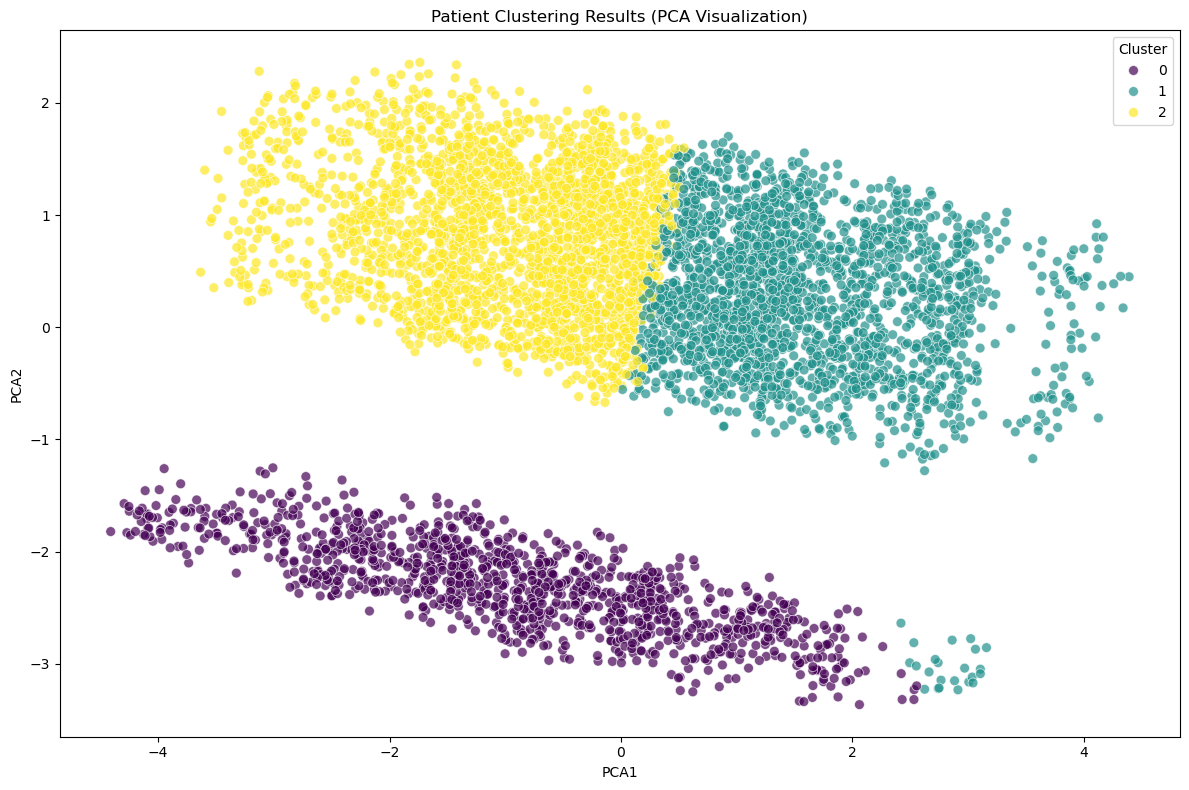

In [24]:
# PCA for visualization (2 components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create dataframe for visualization
pca_df = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'Cluster': cluster_labels
})


# Plot clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=50, alpha=0.7)
plt.title('Patient Clustering Results (PCA Visualization)')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


In [25]:
# Use best_k from silhouette analysis
best_k = 3  # Or use optimal_k from earlier calculation

kmeans = KMeans(n_clusters=best_k, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

print(f"Final Silhouette Score with k={best_k}: {silhouette_score(X_scaled, df['kmeans_cluster']):.4f}")


Final Silhouette Score with k=3: 0.1066


In [26]:
from sklearn.decomposition import PCA

# Try PCA before clustering to see if it improves results
pca = PCA(n_components=5)  # Reduce to 5 principal components
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=best_k, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(X_pca)

print(f"New Silhouette Score after PCA: {silhouette_score(X_pca, df['kmeans_cluster']):.4f}")


New Silhouette Score after PCA: 0.2320


In [27]:
df['kmeans_cluster'].value_counts()

kmeans_cluster
1    2607
0    2229
2    1164
Name: count, dtype: int64

In [28]:
# Select only numeric columns for the aggregation
numeric_df = df.select_dtypes(include=np.number)

# Group by 'kmeans_cluster' and calculate the mean for numeric columns only
cluster_profiles = numeric_df.groupby('kmeans_cluster').mean()
print("Cluster Profiles:")
print(cluster_profiles)

Cluster Profiles:
                      age    gender  chest_pain_type  blood_pressure  \
kmeans_cluster                                                         
0               55.346792  0.466577         2.206371      134.235083   
1               52.497890  0.451477         2.782892      133.709244   
2               53.021478  0.458763         2.524055      134.871134   

                cholesterol  max_heart_rate  exercise_angina  plasma_glucose  \
kmeans_cluster                                                                 
0                229.968596      158.199192         0.509646      160.554509   
1                192.575374      160.630610         0.498274      161.451093   
2                209.986254       84.695876         0.501718      161.920103   

                skin_thickness     insulin        bmi  diabetes_pedigree  \
kmeans_cluster                                                             
0                    60.188874  129.455810  30.188431           1.30

In [29]:
# Perform KMeans clustering with 5 clusters
n_clusters = 5 
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to original data
df['cluster'] = cluster_labels

In [30]:
# Analyze cluster characteristics
cluster_analysis = df.groupby('cluster')[numerical_features + binary_features].mean().round(2)
print("\nCluster Analysis (Mean Values):")
print(cluster_analysis)


Cluster Analysis (Mean Values):
           age  blood_pressure  cholesterol  max_heart_rate    bmi  \
cluster                                                              
0        54.57          134.01       230.21          160.19  29.74   
1        53.76          132.65       189.75          159.89  29.42   
2        53.01          134.22       189.59          160.31  29.93   
3        53.95          134.94       231.18          157.11  30.14   
4        53.01          134.88       209.68           84.71  30.50   

         diabetes_pedigree  plasma_glucose  skin_thickness  insulin  \
cluster                                                               
0                     1.33          164.02           59.80   128.80   
1                     1.30          161.38           59.65   129.26   
2                     1.25          160.57           60.36   130.29   
3                     1.30          158.11           60.31   130.08   
4                     1.29          162.02        

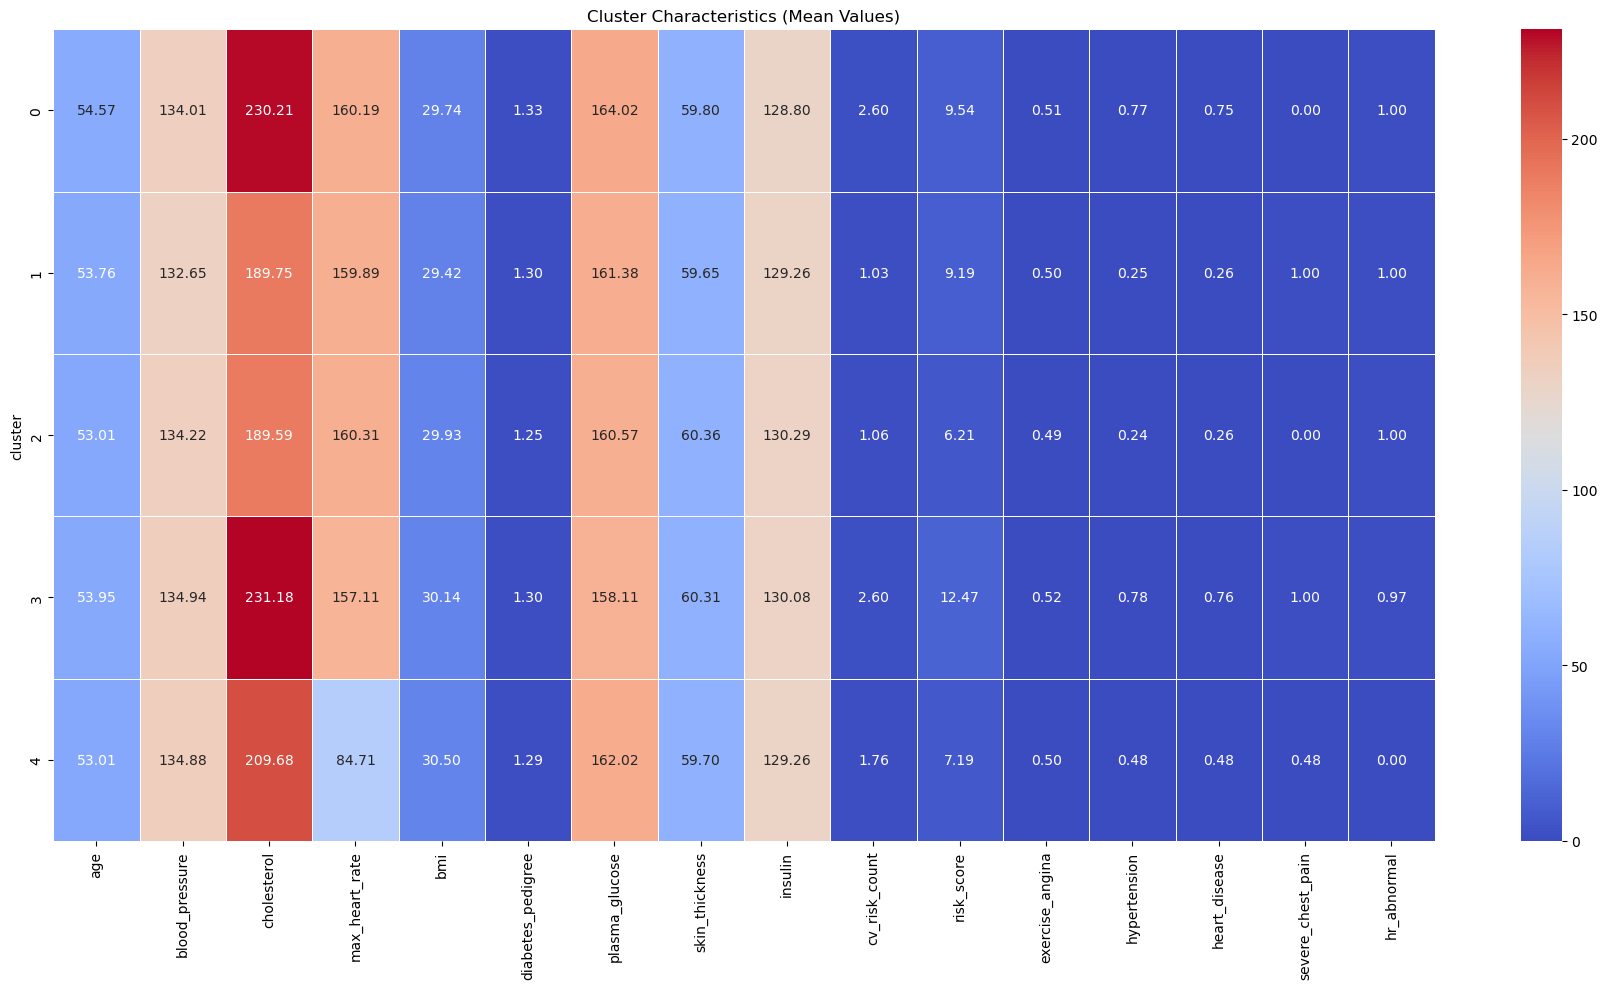

In [31]:
# Create heatmap of cluster characteristics
plt.figure(figsize=(18, 10))
sns.heatmap(cluster_analysis, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Cluster Characteristics (Mean Values)')
plt.tight_layout()
plt.show()

In [32]:
# Define features and target variable
X = df.drop(columns=["kmeans_cluster"])  # Exclude target column
y = df["kmeans_cluster"]  # Target variable

In [33]:
# Before scaling, select only numerical features
X = X.select_dtypes(include=np.number)

In [34]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [35]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [36]:
# Train a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [37]:
# Make predictions
y_pred_rf = rf.predict(X_test)

In [38]:
# Evaluate Random Forest model
print("Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Random Forest Performance:
Accuracy: 0.9775
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       446
           1       0.97      0.99      0.98       521
           2       1.00      0.99      0.99       233

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200

Confusion Matrix:
 [[429  17   0]
 [  7 514   0]
 [  3   0 230]]


In [39]:
# Train an XGBoost Classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [40]:
y_pred_xgb = xgb.predict(X_test)

In [41]:
# Evaluate XGBoost model
print("\nXGBoost Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))



XGBoost Performance:
Accuracy: 0.9858333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       446
           1       0.98      0.99      0.98       521
           2       1.00      1.00      1.00       233

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200

Confusion Matrix:
 [[435  11   0]
 [  5 516   0]
 [  1   0 232]]


In [42]:
sil_scores = []
k_values = range(2, 11)  # Testing for clusters between 2 and 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Find the best k value
best_k = k_values[sil_scores.index(max(sil_scores))]
print(f"Best number of clusters: {best_k}")

# Train the final KMeans model with the best K
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['Cluster'] = final_kmeans.fit_predict(X_scaled)


Best number of clusters: 3


In [43]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best Parameters for Random Forest:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

# Evaluate model
y_pred_rf = best_rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Best Parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 50}
Random Forest Accuracy: 0.9791666666666666
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       446
           1       0.97      0.99      0.98       521
           2       1.00      0.99      1.00       233

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200



In [ ]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10]
}

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("Best Parameters for XGBoost:", grid_xgb.best_params_)
best_xgb = grid_xgb.best_estimator_

# Evaluate model
y_pred_xgb = best_xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


Best Parameters for XGBoost: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100}
XGBoost Accuracy: 0.9816666666666667
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       446
           1       0.98      0.99      0.98       521
           2       1.00      0.99      0.99       233

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200



In [46]:
import pickle

# Save KMeans Model
with open("kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

# Save Random Forest Model
with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(rf, f)

# Save XGBoost Model
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(xgb, f)
